In [1]:
#-----------WARNING-----------WARNING-----------WARNING-----------WARNING-----------WARNING-----------WARNING
#Running the whole notebook without a GPU, CUDA, CUDNN, and Tensorflow-GPU may take 8+ hours of compiling per model
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.
/home/allankim/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/allankim/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/allankim/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/allankim/anaconda3/lib/python3.7/site-packag

In [24]:
# get all the data in the directory split/test, and reshape them
data_test = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        'Images/DATASET/TEST', 
        target_size=(350, 350), 
        batch_size = 500, 
        seed = 1234) 

Found 2513 images belonging to 2 classes.


In [27]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        'Images/DATASET/TRAIN', 
        target_size=(350, 350), 
        batch_size = 6500, 
        seed = 1234) 

Found 22564 images belonging to 2 classes.


In [28]:
#split images and labels
images_train, labels_train = next(data_train)
images_test, labels_test= next(data_test)

#Merging all images and labels
images = np.concatenate((images_train, images_test))
labels = np.concatenate((labels_train[:,0], labels_test[:,0]))

#Creating Random Split for test data
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=1234)

#Creating Random Split for validation and training data
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=1234)

In [29]:
#Creating Convolutional Neural Network
cnn = models.Sequential()

#1st Layer
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(350, 350,  3), padding='SAME'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(Dropout(p = 0.1))

#2nd Layer
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(Dropout(p = 0.1))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(64, activation='relu'))

#Output Layer
cnn.add(layers.Dense(1, activation='sigmoid'))

#Configuring CNN
cnn.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [31]:
#Training CNN
cnn1 = cnn.fit(X_train,
               y_train,
               
               epochs=50,

               
               validation_data=(X_val, y_val))

Train on 4480 samples, validate on 1120 samples
Epoch 1/50
4480/4480 [==============================] - 21s 5ms/step - loss: 0.4321 - accuracy: 0.8092 - val_loss: 0.4475 - val_accuracy: 0.7902
Epoch 2/50
4480/4480 [==============================] - 21s 5ms/step - loss: 0.4136 - accuracy: 0.8188 - val_loss: 0.4777 - val_accuracy: 0.7839
Epoch 3/50
4480/4480 [==============================] - 21s 5ms/step - loss: 0.4075 - accuracy: 0.8248 - val_loss: 0.4179 - val_accuracy: 0.8143
Epoch 4/50
4480/4480 [==============================] - 21s 5ms/step - loss: 0.3962 - accuracy: 0.8299 - val_loss: 0.4239 - val_accuracy: 0.8196
Epoch 5/50
4480/4480 [==============================] - 21s 5ms/step - loss: 0.3834 - accuracy: 0.8357 - val_loss: 0.4118 - val_accuracy: 0.8205
Epoch 6/50
4480/4480 [==============================] - 21s 5ms/step - loss: 0.3675 - accuracy: 0.8460 - val_loss: 0.4105 - val_accuracy: 0.8214
Epoch 7/50
4480/4480 [==============================] - 21s 5ms/step - loss: 0.369

KeyboardInterrupt: 

In [ ]:
# #pre-processing images taken from keras documentation
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#     rescale=1./255)

# test_datagen = ImageDataGenerator(rescale=1./255)

# training_set = train_datagen.flow_from_directory(
#     'Images/DATASET/TRAIN',
#     target_size=(255, 255),
#     batch_size=8500,
#     class_mode='binary')

# test_set = test_datagen.flow_from_directory(
#     'Images/DATASET/TEST',
#     target_size=(255, 255),
#     batch_size=850,
#     class_mode='binary')

# # class1 = cnn.fit(
# #     training_set,
# #      steps_per_epoch=2000,
# #     epochs=50,
# #     validation_data=test_set)
# # #     validation_steps=500,
# # #     workers=2500)

In [ ]:
#CNN Model Summary
print(cnn.summary())

In [ ]:
#Extracting CNN Results for Visualization
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['accuracy'] 
val_acc_values = hist_cnn['val_accuracy']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss - 2-Layer CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy - 2-Layer CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('Images/Model/cnn1.png')
plt.show()

In [ ]:
#CNN Metrics
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print()
print('CNN [Loss, Accuracy]')
print('CNN TRAIN IMAGES: ', results_train)
print()
print('CNN TEST IMAGES: ', results_test)

## 2-Layer CNN with Transfer Learning (InceptionV3)

In [32]:
#Importing model with weights pre-trained on ImageNet
from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model

In [33]:
#Utilizing InceptionV3 for new CNN
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
cnn2 = models.Sequential()
cnn2.add(imagenet)
cnn2.add(GlobalAveragePooling2D())
cnn2.add(Dense(1024,activation='relu'))
cnn2.add(Dropout(p = 0.1))
cnn2.add(Dense(1024,activation='relu')) #dense layer 2
cnn2.add(Dropout(p = 0.1))
cnn2.add(Dense(512,activation='relu')) #dense layer 3
cnn2.add(Dropout(p = 0.1))
cnn2.add(Dense(1,activation='sigmoid')) #final layer with softmax activation

In [34]:
#Ensuring exracted model is not retrained
for layer in cnn2.layers[:1]:
    layer.trainable=False

In [35]:
cnn2.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

tl_cnn2 = cnn2.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=50,
                   validation_data=(X_val, y_val))

Train on 4480 samples, validate on 1120 samples
Epoch 1/50
4480/4480 [==============================] - 25s 6ms/step - loss: 0.3684 - accuracy: 0.8373 - val_loss: 0.2237 - val_accuracy: 0.9116
Epoch 2/50
4480/4480 [==============================] - 22s 5ms/step - loss: 0.2080 - accuracy: 0.9210 - val_loss: 0.2105 - val_accuracy: 0.9179
Epoch 3/50
4480/4480 [==============================] - 22s 5ms/step - loss: 0.2177 - accuracy: 0.9127 - val_loss: 0.2001 - val_accuracy: 0.9241
Epoch 4/50
4480/4480 [==============================] - 22s 5ms/step - loss: 0.1665 - accuracy: 0.9355 - val_loss: 0.2171 - val_accuracy: 0.9080
Epoch 5/50
4480/4480 [==============================] - 22s 5ms/step - loss: 0.1519 - accuracy: 0.9424 - val_loss: 0.1759 - val_accuracy: 0.9268
Epoch 6/50
4480/4480 [==============================] - 22s 5ms/step - loss: 0.1789 - accuracy: 0.9279 - val_loss: 0.2743 - val_accuracy: 0.8857
Epoch 7/50
4480/4480 [==============================] - 22s 5ms/step - loss: 0.151

In [36]:
cnn2.evaluate(X_test, y_test)

1400/1400 [==============================] - 7s 5ms/step


[0.3561137427176748, 0.9157142639160156]

In [37]:
predictions_transfer = cnn2.predict(X_test)
predictions_transfer = np.around(predictions_transfer)

In [38]:
f1_score(y_test, predictions_transfer)

0.9270704573547589

In [39]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[532 106]
 [ 12 750]]


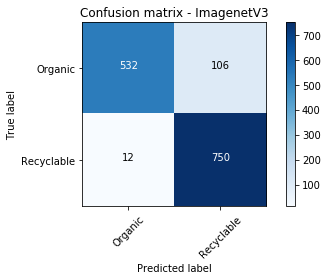

In [40]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predictions_transfer), classes=['Organic', 'Recyclable'], normalize=False,
                      title='Confusion matrix - ImagenetV3')
# plt.savefig('Images/Model/CF_TL1.png')
plt.show()

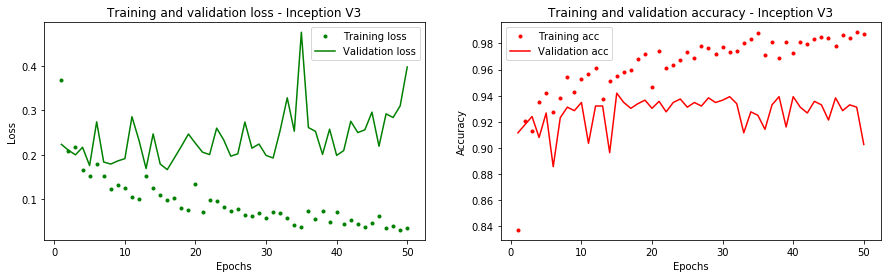

In [41]:
#Extracting CNN Results for Visualization
hist_cnn = tl_cnn2.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['accuracy'] 
val_acc_values = hist_cnn['val_accuracy']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss - Inception V3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Inception V3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('Images/Model/cnn2.png')
plt.show()

In [42]:
def predictoneimage_cnn(model, path):
    img = load_img(path, target_size=(224, 224))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    return predict

array([[0.9997898]], dtype=float32)

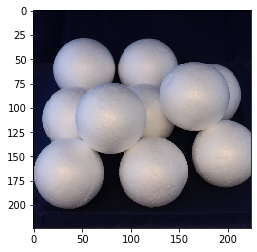

In [43]:
predictoneimage_cnn(cnn2, 'Images/Sample_Images/styro.jpg')

ValueError: Error when checking input: expected conv2d_5_input to have shape (350, 350, 3) but got array with shape (224, 224, 3)

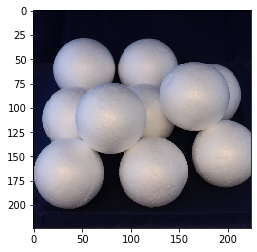

In [44]:
predictoneimage_cnn(cnn, 'Images/Sample_Images/styro.jpg')

In [ ]:
#Saving Models
# cnn.save('image_class1_v2.h5')
# cnn2.save('image_class1_tl_v2.h5')

## 3 Layer CNN

In [ ]:
cnn3 = models.Sequential()

#1st Layer
cnn3.add(layers.Conv2D(128, (3, 3), input_shape=(224, 224,  3), padding='SAME'))
cnn3.add(layers.Activation('relu'))
cnn3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(p = 0.1))

#2nd Layer
cnn3.add(layers.Conv2D(64, (3, 3)))
cnn3.add(layers.Activation('relu'))
cnn3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(p = 0.1))

#3rd Layer
cnn3.add(layers.Conv2D(32, (3, 3)))
cnn3.add(layers.Activation('relu'))
cnn3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(p = 0.1))

#Dense and output Layers
cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(32))
cnn3.add(layers.Activation('relu'))
cnn3.add(layers.Dropout(0.5))
cnn3.add(layers.Dense(1))
cnn3.add(layers.Activation('sigmoid'))

#Configuring the model
cnn3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
cnn_3l = cnn3.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=32,
                  validation_data=(X_val, y_val))

In [ ]:
print(cnn3.summary())

In [ ]:
#Extracting CNN Results for Visualization
hist_cnn = cnn_3l.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['accuracy'] 
val_acc_values = hist_cnn['val_accuracy']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss - 3-Layer CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy - 3-Layer CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('Images/Model/cnn3.png')
plt.show()

In [ ]:
cnn3.save('image_class2_3l_v2.h5')

## 3-Layer CNN with Transfer Learning (Xception)

In [ ]:
#Importing pre-trained model
from keras.applications import xception

In [ ]:
#Creating pre-trained CNN Model
imagenet2 = xception.Xception(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
imagenet2_res = imagenet2.output
cnn3_tl = models.Sequential()
cnn3_tl.add(imagenet2)
cnn3_tl.add(GlobalAveragePooling2D())
cnn3_tl.add(Dense(1024,activation='relu'))
cnn3_tl.add(Dense(1024,activation='relu')) 
cnn3_tl.add(Dense(512,activation='relu')) 
cnn3_tl.add(Dense(1,activation='sigmoid'))

In [ ]:
#Ensuring exracted model is not retrained
for layer in cnn3_tl.layers[:1]:
    layer.trainable=False

In [ ]:
cnn3_tl.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

tl_cnn3 = cnn3_tl.fit(X_train,
                      y_train,
                      epochs=10,
                      batch_size=50,
                      validation_data=(X_val, y_val))

In [ ]:
print(cnn3_tl.summary())

In [ ]:
#Extracting CNN Results for Visualization
hist_cnn = tl_cnn3.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['accuracy'] 
val_acc_values = hist_cnn['val_accuracy']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss - Xception Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Xception Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('Images/Model/cnn3_tl.png')
plt.show()

In [ ]:
#Check if it can classify a confusing image of styrofoam ball
predictoneimage_cnn(cnn3_tl, 'Images/Sample_Images/styro.jpg')

In [ ]:
#Checking the Robot
predictoneimage_cnn(cnn3_tl, 'Images/Sample_Images/robot.jpg')

In [ ]:
# cnn3_tl.save('image_class2_3l_tl_v2.h5')

In [ ]:
def image_predictor(path):
    img = load_img(path, target_size=(224, 224))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)    
    pred1 = cnn.predict(img)
    pred2 = cnn3.predict(img)
    pred3 = cnn2.predict(img)
    pred4 = cnn3_tl.predict(img)
    return pred1, pred2, pred3, pred4

In [ ]:
def predictor_output(path):
    mod1, mod2, mod3, mod4 = image_predictor(path)
    print('VALUE Interpretation:')
    print()
    print('Closer to 1 is Organic, Closer to 0 is Recyclable')
    print()
    print('2-LAYER CNN:')
    print(mod1)
    print()
    print('3-Layer CNN:')
    print(mod2)
    print()
    print('Inception ver3 CNN')
    print(mod3)
    print()
    print('Xception CNN')
    print(mod4)

In [ ]:
#Sample Prediction
predictor_output('Images/Sample_Images/robot.jpg')